# Your First AI application


Finished by HG 

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [17]:
# The new version of dataset is only available in the tfds-nightly package.
%pip --no-cache-dir install tfds-nightly --user
# DON'T MISS TO RESTART THE KERNEL

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfds.disable_progress_bar()

In [2]:
# TODO: Make all other necessary imports.
import numpy as np
import matplotlib.pyplot as plt
tfds.disable_progress_bar() #it's annoying
print(' TensorFlow version:', tf.__version__)
print(' tf.keras version:', tf.keras.__version__)

 TensorFlow version: 2.0.0
 tf.keras version: 2.2.4-tf


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()



dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
# TODO: Create a training set, a validation set and a test set.
training_dataset = dataset['train']
testing_dataset = dataset['test']
validation_dataset = dataset['validation']

I0620 10:21:49.047259 140017091176192 download_and_prepare.py:201] Running download_and_prepare for dataset(s):
oxford_flowers102
I0620 10:21:49.048565 140017091176192 dataset_info.py:358] Load dataset info from /root/tensorflow_datasets/oxford_flowers102/2.1.1
I0620 10:21:49.061144 140017091176192 download_and_prepare.py:139] download_and_prepare for dataset oxford_flowers102/2.1.1...
I0620 10:21:49.061424 140017091176192 dataset_builder.py:287] Reusing dataset oxford_flowers102 (/root/tensorflow_datasets/oxford_flowers102/2.1.1)
name: "oxford_flowers102"
description: "The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring\nin the United Kingdom. Each class consists of between 40 and 258 images. The images have\nlarge scale, pose and light variations. In addition, there are categories that have large\nvariations within the category and several very similar categories.\n\nThe dataset is divided into a training set, a validation set and a test set.\nT

## Explore the Dataset

In [4]:
# TODO: Get the number of examples in each set from the dataset info.

num_test = dataset_info.splits['test'].num_examples
num_train = dataset_info.splits['train'].num_examples
num_valid = dataset_info.splits['validation'].num_examples
print('number of testing set examples:',num_test)
print('number of training set examples:',num_train)
print('number of validation set examples:',num_valid)

# TODO: Get the number of classes in the dataset from the dataset info.
print('number of flower classes:', dataset_info.features['label'].num_classes)

number of testing set examples: 6149
number of training set examples: 1020
number of validation set examples: 1020
number of flower classes: 102


In [5]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
i = 1
for image, label in training_dataset.take(3):
    print('image {} with shape {} and type {}'.format(i, image.shape, label))
    i +=1

image 1 with shape (500, 667, 3) and type 72
image 2 with shape (500, 666, 3) and type 84
image 3 with shape (670, 500, 3) and type 70


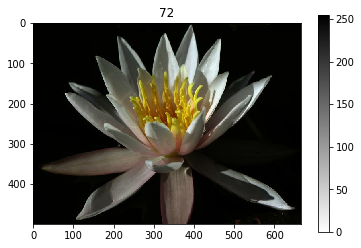

In [6]:
# TODO: Plot 1 image from the training set. 
for image, label in training_dataset.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.title(label)
    plt.show()
# Set the title of the plot to the corresponding image label. 

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)


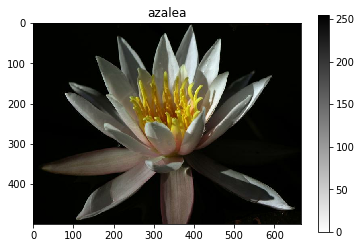

In [8]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in training_dataset.take(1):
    image = image.numpy().squeeze()
    label = str(label.numpy())
    
    plt.imshow(image, cmap=plt.cm.binary)
    plt.colorbar()
    plt.title(class_names[label])
    plt.show()

## Create Pipeline

In [9]:
# TODO: Create a pipeline for each set.
batch_size = 32
image_size = 224

def normlize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label



training_batches = training_dataset.cache().shuffle(num_test//4).map(normlize).batch(batch_size).prefetch(1)
testing_batches = testing_dataset.cache().map(normlize).batch(batch_size).prefetch(1)
validation_batches = validation_dataset.cache().map(normlize).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [10]:
#importing the pre-trained model
URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size, 3))
feature_extractor.trainable= False


In [11]:
# TODO: Build and train your network.
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(102, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
#checking GPU availability
print('Is there a GPU Available:', tf.test.is_gpu_available())

Is there a GPU Available: True


In [13]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(training_batches,
                    epochs=30,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 14s 441ms/step - loss: 4.2285 - accuracy: 0.1284 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 5s 153ms/step - loss: 2.0658 - accuracy: 0.6824 - val_loss: 1.9969 - val_accuracy: 0.6216
Epoch 3/30
32/32 [==============================] - 5s 153ms/step - loss: 1.1206 - accuracy: 0.8892 - val_loss: 1.5307 - val_accuracy: 0.7078
Epoch 4/30
32/32 [==============================] - 5s 153ms/step - loss: 0.6775 - accuracy: 0.9559 - val_loss: 1.2932 - val_accuracy: 0.7578
Epoch 5/30
32/32 [==============================] - 5s 154ms/step - loss: 0.4520 - accuracy: 0.9843 - val_loss: 1.1514 - val_accuracy: 0.7745
Epoch 6/30
32/32 [==============================] - 5s 153ms/step - loss: 0.3222 - accuracy: 0.9931 - val_loss: 1.0719 - val_accuracy: 0.7814
Epoch 7/30
32/32 [==============================] - 5s 153ms/step - loss: 0.2354 - accuracy: 0.9971 - val_loss: 1.0009 - val_accuracy: 0.78

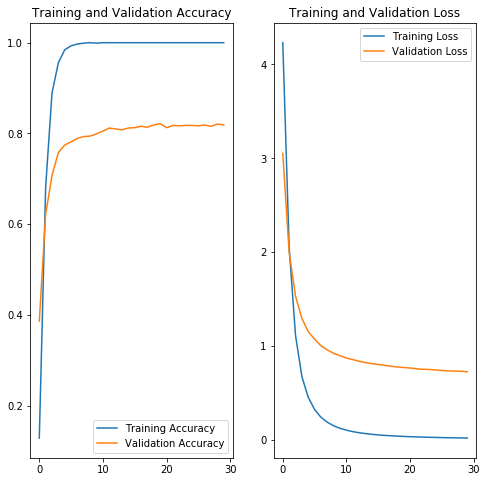

In [14]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [15]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(testing_batches)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))


193/193 [==============================] - 20s 106ms/step - loss: 0.8612 - accuracy: 0.7866

Loss after training: 0.861
Accuracy after training: 78.663%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [17]:
# TODO: Save your trained model as a Keras model.
#import time
#t = time.time()

saved_model_path = './best_model.h5'

model.save(saved_model_path)


## Load the Keras Model

Load the Keras model you saved above.

In [18]:
# TODO: Load the Keras model
reloaded_model = tf.keras.models.load_model(saved_model_path, custom_objects={'KerasLayer': hub.KerasLayer})
reloaded_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [19]:
# TODO: Create the process_image function
def process_image(test):
    image_processed = np.squeeze(test)
    image_processed = tf.image.resize(image_processed, (224,224))
    image_processed /=255
    return image_processed



To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

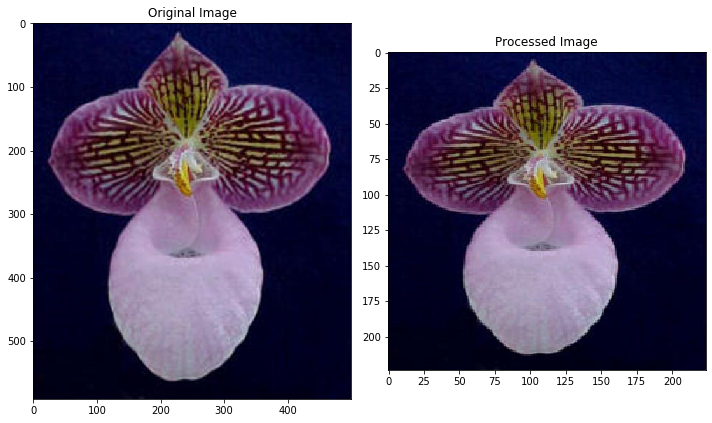

In [20]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [21]:
# TODO: Create the predict function
def predict(image_path, model, top_k=5):
    img = Image.open(image_path) #open the image
    predict_image = process_image(np.asanyarray(img))# process the image
    prediction = model.predict(np.expand_dims(predict_image,axis=0))#predict the image
    prop, indices = tf.math.top_k(prediction, top_k)# find best probabilities and classes
    prop = prop.numpy()[0]#extract the propability
    flowername = [class_names[str(value+1)] for value in indices.cpu().numpy()[0]]#change the class num into flower name 
    return prop, flowername

In [22]:
predict('./test_images/cautleya_spicata.jpg', model)

Instructions for updating:
Use tf.identity instead.


Instructions for updating:
Use tf.identity instead.


(array([0.93437546, 0.02694771, 0.01817127, 0.00371516, 0.00298278],
       dtype=float32),
 ['cautleya spicata', 'red ginger', 'wallflower', 'siam tulip', 'snapdragon'])

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

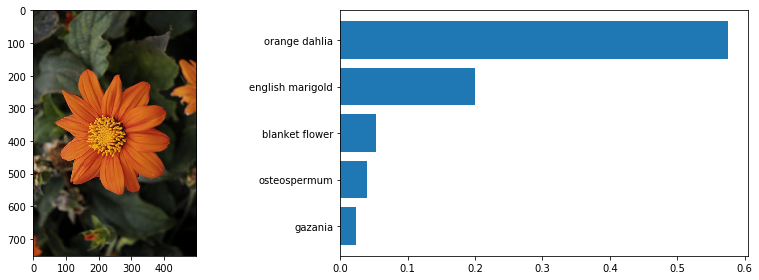

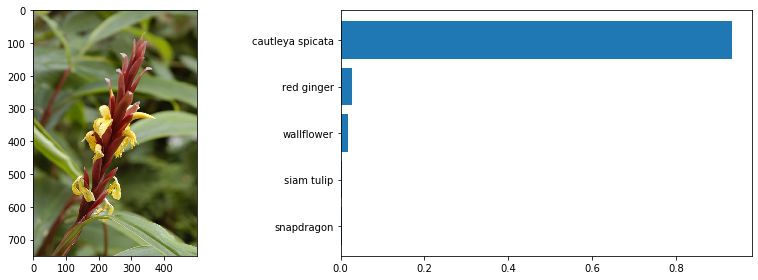

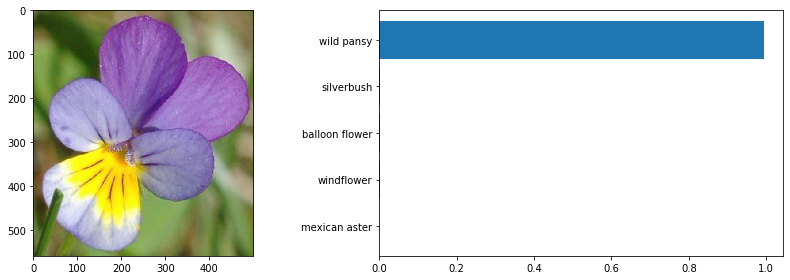

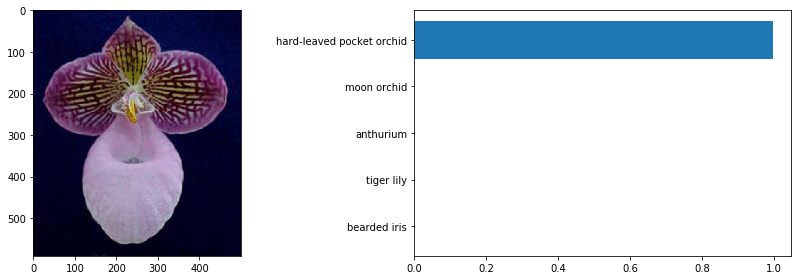

In [23]:
# TODO: Plot the input image along with the top 5 classes
import glob
files= glob.glob('./test_images/*.jpg')

for image_paths in files:                                   #loop through the images in the file
    img = Image.open(image_paths)                           # open the image
    predict_image = process_image(np.asanyarray(img))       # procces the image
    prop, classes = predict(image_paths, model, 5)          # get the probabilities and classes(by number)
    fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2) # make two figures (for image, probabilities)
    ax1.imshow(img)                                         #show the image
    ax2 = plt.barh(classes[::-1], prop[::-1])               #show the probabilities
    plt.tight_layout()                                      #fix the subplots
    plt.show()                                              #show the whole thing

In [24]:
!jupyter nbconvert *.ipynb


[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html
[NbConvertApp] Writing 1439662 bytes to Project_Image_Classifier_Project.html
